In [30]:
import os

import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import seaborn as sns

from datetime import datetime

In [31]:
start = datetime.now()
print("start = ", start)
try:
    
    mydb = mysql.connector.connect(
        host=os.environ['MYSQL_SPOTIFY_HOST'],
        user=os.environ['MYSQL_SPOTIFY_USER'],
        password=os.environ['MYSQL_SPOTIFY_PW'],
        database="wilts_songs"
    )

    mycursor = mydb.cursor()
    mycursor.execute("""SELECT * FROM songs;""")

    data = mycursor.fetchall()
except mysql.connector.Error as error:
    print("Failed to insert into MySQL table {}".format(error))

finally:
    if mydb.is_connected():
        mycursor.close()
        mydb.close()
        print("MySQL connection is closed")
    end = datetime.now()
    print("finish = ", end)
    print("duration = ", (end-start).total_seconds())

start =  2022-02-18 16:22:26.129285
MySQL connection is closed
finish =  2022-02-18 16:22:26.205359
duration =  0.076074


In [32]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [33]:
columns = ['id', 'track_name', 'artist_name', 'popularity', 'duration_ms',
        'danceability', 'time_signature', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo']

nominal_cols = ['id', 'track_name', 'artist_name']
discret_cols = ['key', 'mode']
continuous_cols = ['popularity', 'duration_ms', 'danceability', 'time_signature', 'energy', 'loudness', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo'] 
useful_cols = discret_cols + continuous_cols

In [34]:
df = pd.DataFrame(data, columns=columns)

In [35]:
df.describe()

,popularity,duration_ms,danceability,time_signature,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,18209.000000,1.820900e+04,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000,18209.000000
mean,53.534681,2.349242e+05,0.570275,3.913065,0.594110,5.239167,-9.506448,0.705420,0.071309,0.314549,0.097785,0.198077,0.560166,120.248642
std,19.853799,9.038462e+04,0.166637,0.371238,0.237698,3.521069,4.475365,0.455866,0.079428,0.312929,0.244145,0.173292,0.251719,28.945378
min,0.000000,3.062200e+04,0.000000,0.000000,0.000020,0.000000,-47.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,1.811330e+05,0.458000,4.000000,0.423000,2.000000,-11.930000,0.000000,0.033000,0.031200,0.000000,0.091800,0.362000,97.867000
50%,57.000000,2.230790e+05,0.578000,4.000000,0.612000,5.000000,-8.755000,1.000000,0.042200,0.201000,0.000049,0.129000,0.569000,119.397000
75%,67.000000,2.703330e+05,0.689000,4.000000,0.791000,8.000000,-6.275000,1.000000,0.067500,0.568000,0.009100,0.252000,0.771000,136.837000
max,100.000000,1.644773e+06,0.988000,5.000000,1.000000,11.000000,0.899000,1.000000,0.954000,0.996000,1.000000,0.997000,0.993000,243.372000


We will have to scale the datas to have all of them approximately at the same scale for the distance calculated to be relevant. 
The nominal cols (id, track_name and artist_name) won't be used for the model, they are simply kept to know which songs the data refers to. 

## Checking the distribution 

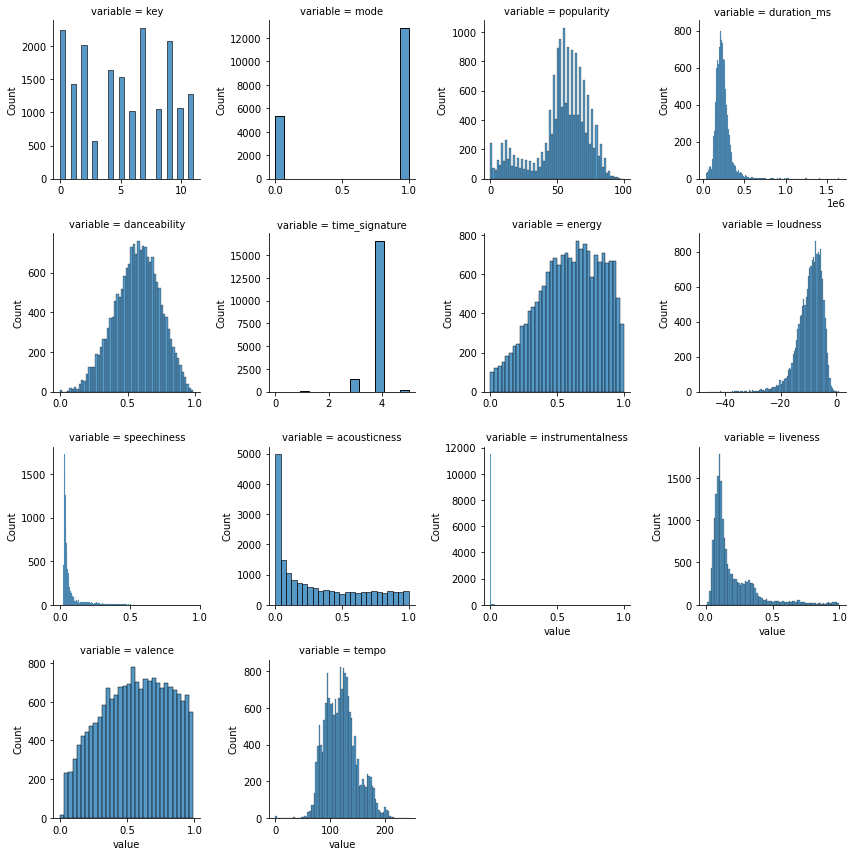

In [36]:
# Grid of distribution plots of all numerical features
f = pd.melt(df[useful_cols])
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value')

time_signature seems to have mainly one value. 
duration_ms, speechiness and instrumentalness seems to have outliers that we may need to deal with.
The remaining values seem to be usable. 

RETIRER UN %AGE ? => A voir suivant ce que le modèle donne (si les valeurs extrêmes sont vraiment éloignées du reste des clusters)

In [37]:
(df.speechiness >= 0.5).sum()/df.speechiness.shape[0]*100

0.274589488714372

In [38]:
df.speechiness.quantile(q=0.95)

0.249

In [39]:
df.speechiness.quantile(q=0.99)

0.398

In [40]:
df.instrumentalness.quantile(q=0.8)

0.030340000000000145

In [41]:
df.instrumentalness.quantile(q=0.95)

0.827

In [42]:
df.duration_ms.quantile(q=0.95)

383541.39999999997

## Checking what is the percentage of the most used value

In [43]:
sparsity = pd.DataFrame()

sparsity['Value'] = df[useful_cols].apply(lambda column: column.mode().values[0])
sparsity['Percentage of value'] = df.apply(lambda column: round(column[column == column.mode().values[0]].count()/column.shape[0]*100,2))
sparsity.sort_values(by="Percentage of value", ascending=False)

,Value,Percentage of value
time_signature,4.0000,90.91
mode,1.0000,70.54
instrumentalness,0.0000,30.68
key,7.0000,12.50
popularity,55.0000,2.91
liveness,0.1080,0.94
speechiness,0.0305,0.51
valence,0.9610,0.46
danceability,0.5960,0.36
energy,0.6200,0.22


time_signature has the value 4 in more than 90% of the time. But the value may be relevant for the clustering because it's an important feature in music, so I will keep it until we can check with the model if it's better to keep it or not. 

## Visualisation de la corrélation entre les variables

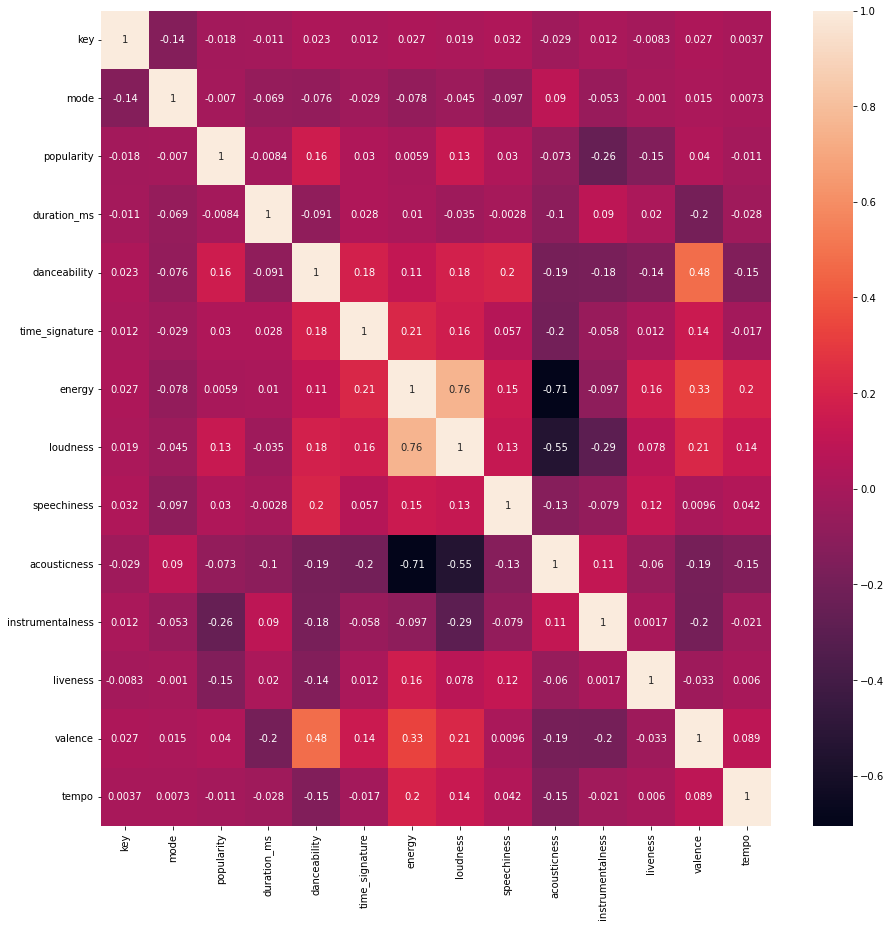

In [44]:
ax=sns.heatmap(df[useful_cols].corr(), xticklabels=True, yticklabels=True, annot=True)
fig = plt.gcf()
# Modifie la taille du graphique
fig.set_size_inches(15,15)

In [45]:
df[useful_cols].corr()

,key,mode,popularity,duration_ms,danceability,time_signature,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
key,1.000000,-0.137140,-0.018142,-0.011045,0.023164,0.012126,0.026771,0.019014,0.031695,-0.028834,0.012284,-0.008264,0.026632,0.003659
mode,-0.137140,1.000000,-0.007039,-0.069347,-0.075975,-0.029311,-0.077630,-0.045361,-0.096646,0.090439,-0.053414,-0.001012,0.015443,0.007340
popularity,-0.018142,-0.007039,1.000000,-0.008377,0.159451,0.029921,0.005906,0.129394,0.029988,-0.073439,-0.255440,-0.150437,0.039743,-0.010575
duration_ms,-0.011045,-0.069347,-0.008377,1.000000,-0.090636,0.027606,0.010448,-0.034988,-0.002848,-0.101436,0.089943,0.020134,-0.195331,-0.028396
danceability,0.023164,-0.075975,0.159451,-0.090636,1.000000,0.182312,0.109430,0.184613,0.201944,-0.186753,-0.182498,-0.144415,0.478131,-0.146220
time_signature,0.012126,-0.029311,0.029921,0.027606,0.182312,1.000000,0.214740,0.162819,0.056933,-0.203105,-0.057558,0.012076,0.143960,-0.016763
energy,0.026771,-0.077630,0.005906,0.010448,0.109430,0.214740,1.000000,0.759246,0.145194,-0.705432,-0.096588,0.162414,0.328240,0.196989
loudness,0.019014,-0.045361,0.129394,-0.034988,0.184613,0.162819,0.759246,1.000000,0.125019,-0.545417,-0.293165,0.078165,0.214867,0.137665
speechiness,0.031695,-0.096646,0.029988,-0.002848,0.201944,0.056933,0.145194,0.125019,1.000000,-0.131508,-0.078844,0.118749,0.009560,0.041901
acousticness,-0.028834,0.090439,-0.073439,-0.101436,-0.186753,-0.203105,-0.705432,-0.545417,-0.131508,1.000000,0.110542,-0.059556,-0.192467,-0.152109


There is a rather high correlation between acousticness, energy and loudness especially the energy with the other 2.

In [46]:
corr_col = ['acousticness', 'energy', 'loudness']
df_corr = df[corr_col]
df_corr.corr()

,acousticness,energy,loudness
acousticness,1.000000,-0.705432,-0.545417
energy,-0.705432,1.000000,0.759246
loudness,-0.545417,0.759246,1.000000


In [47]:
df_corr['acousticness/energy']=df_corr['acousticness']/df_corr['energy']
df_corr['loudness/energy']=-df_corr['loudness']/df_corr['energy']
#LE MIEUX (car directement compris entre 0 et 1 et décorrelé avec loudness)
df_corr['acousticness*energy']=df_corr['acousticness']*df_corr['energy']
df_corr['loudness*energy']=-df_corr['loudness']*df_corr['energy']

/tmp/ipykernel_5416/696442939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['acousticness/energy']=df_corr['acousticness']/df_corr['energy']
/tmp/ipykernel_5416/696442939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['loudness/energy']=-df_corr['loudness']/df_corr['energy']
/tmp/ipykernel_5416/696442939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [48]:
from numpy import log
df_corr['acousticness/energy2']=df_corr['acousticness/energy'].apply(lambda x: log(1+x)/x)
df_corr['loudness/energy2']=df_corr['loudness/energy'].apply(lambda x: log(1+x)/x)
df_corr['acousticness*energy2']=df_corr['acousticness*energy'].apply(lambda x: log(1+x)/x)
df_corr['loudness*energy2']=df_corr['loudness*energy'].apply(lambda x: log(1+x)/x)

/tmp/ipykernel_5416/2627893963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['acousticness/energy2']=df_corr['acousticness/energy'].apply(lambda x: log(1+x)/x)
/tmp/ipykernel_5416/2627893963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['loudness/energy2']=df_corr['loudness/energy'].apply(lambda x: log(1+x)/x)
/tmp/ipykernel_5416/2627893963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [49]:
df_corr.corr()

,acousticness,energy,loudness,acousticness/energy,loudness/energy,acousticness*energy,loudness*energy,acousticness/energy2,loudness/energy2,acousticness*energy2,loudness*energy2
acousticness,1.000000,-0.705432,-0.545417,0.025828,0.014449,0.719626,-0.358213,-0.950900,-0.592492,-0.737643,0.392121
energy,-0.705432,1.000000,0.759246,-0.034374,-0.037916,-0.204076,0.420558,0.824627,0.865176,0.237314,-0.445783
loudness,-0.545417,0.759246,1.000000,-0.075970,-0.072281,-0.075657,-0.062433,0.682172,0.847840,0.095330,-0.109375
acousticness/energy,0.025828,-0.034374,-0.075970,1.000000,0.878221,-0.011658,-0.035385,-0.049405,-0.026342,0.012542,0.086021
loudness/energy,0.014449,-0.037916,-0.072281,0.878221,1.000000,-0.015056,-0.040019,-0.049058,-0.029009,0.014360,0.100845
acousticness*energy,0.719626,-0.204076,-0.075657,-0.011658,-0.015056,1.000000,-0.019032,-0.504824,-0.188552,-0.996222,-0.025338
loudness*energy,-0.358213,0.420558,-0.062433,-0.035385,-0.040019,-0.019032,1.000000,0.450892,-0.016354,0.033677,-0.895972
acousticness/energy2,-0.950900,0.824627,0.682172,-0.049405,-0.049058,-0.504824,0.450892,1.000000,0.686844,0.531724,-0.523194
loudness/energy2,-0.592492,0.865176,0.847840,-0.026342,-0.029009,-0.188552,-0.016354,0.686844,1.000000,0.216591,-0.009400
acousticness*energy2,-0.737643,0.237314,0.095330,0.012542,0.014360,-0.996222,0.033677,0.531724,0.216591,1.000000,0.014922


In [50]:
df_corr.describe()

,acousticness,energy,loudness,acousticness/energy,loudness/energy,acousticness*energy,loudness*energy,acousticness/energy2,loudness/energy2,acousticness*energy2,loudness*energy2
count,18209.000000,18209.000000,18209.000000,18209.000000,1.820900e+04,18209.000000,18209.000000,18208.000000,18209.000000,18208.000000,18209.000000
mean,0.314549,0.594110,-9.506448,5.688833,3.042727e+02,0.134408,4.840247,0.793783,0.200690,0.942211,0.383609
std,0.312929,0.237698,4.475365,375.176746,1.900392e+04,0.129817,1.791440,0.215448,0.105550,0.051687,0.088813
min,0.000000,0.000020,-47.070000,0.000000,-8.990000e-01,0.000000,-0.899000,0.000231,0.000007,0.717948,0.175389
25%,0.031200,0.423000,-11.930000,0.044676,8.327970e+00,0.020380,3.613049,0.663041,0.124050,0.905652,0.326834
50%,0.201000,0.612000,-8.755000,0.325641,1.425614e+01,0.101432,4.666978,0.865648,0.191144,0.952463,0.371687
75%,0.568000,0.791000,-6.275000,1.164763,2.680556e+01,0.215344,5.917590,0.978281,0.268135,0.989945,0.423158
max,0.996000,1.000000,0.899000,46502.463054,1.992562e+06,0.877184,16.230780,0.999999,2.550206,1.000000,2.550206


In [4]:
print("?", '!', '.')

? ! .


In [2]:
1.644773e+06

1644773.0

In [3]:
1644/60

27.4